# The COVID-19 Burden
In this work we will look at the how the current count of COVID deaths compares with the expected number of deaths in a country based on historical data, using data from [OWID](https://ourworldindata.org). We will calculate the _covid burden_ as the number of COVID-19 deaths as a fraction of expected deaths over the same period of time (from thye date of the first confirmed COVID death in a country) and we will calculate where this positions COVID-19 in the ranking of mortality causes for a given country.

Reasonably early in the pandemic there was a line of thought that predicted a natural brake on COVID-19, based on an analysis that argued against the prevailing view of exponential growth, and in favour of an alternative growth dynamic that would see the virus burning out sooner than expected, and limiting fatalities at a level of approximately one month's worth of historical deaths for a given country (that is, a COVID burden of 1/12 or approximately 8%). We will discuss whether this holds up based on the current data.

A major caveat to this work concerns the many different ways that COVID-19 deaths are counted around the world. This makes it challenging to compare countries on a genuine _like-for-like_ basis. There are at least two reasons to this. First, countries apply [different policies](https://ourworldindata.org/excess-mortality-covid) when registering COVID-19 deaths. For example, some countries only report hospital deaths, others only report deaths arising from a positive COVID test, while others include suspected COVID-19 deaths. A related issue is so-called _excess mortality_, the number of deaths due to COVID that would not have ordinarily occurred. Some [analyses](https://www.ft.com/content/6bd88b7d-3386-4543-b2e9-0d5c6fac846c) highlight significant excess deaths above and beyond historical norms and different countries appear to have very different excess mortality numbers, in no small part because of reporting differences. This means that we do not currently have a consistent accounting for COVID-19 deaths, and probbaly won't for some time, perhaps long after the pandemic has receeded.

In this work the COVID burden is not an excess mortality estimate, rather it serves as a guide with which to contextualise current COVID-19 fatality rates with respect to common causes of mortality in a given country, and with this in mind we estimate the COVID burden and the corresponding all-cause mortality ranking for 173 countries for which data is available.



In [1]:
import math

from datetime import date, datetime, timedelta


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import matplotlib


import seaborn as sns

import plotly.io as pio
import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from IPython.display import clear_output


import sys
import os
sys.path.insert(0, os.path.abspath('../../src/'))
import pipeline

from scipy.stats import ttest_ind

import geopandas as gpd

from scipy.stats import linregress
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison



import sys
import os
sys.path.insert(0, os.path.abspath('../src/'))
import pipeline



%matplotlib inline

!pwd

/home/barry/projects/covid_projects/fatality_analysis/notebooks


# Loading Datasets
There are two key datasets: the usualy COVID dataset and a mortality dataset. Both are available from OWID.

## COVID Base

In [2]:
df = pd.read_pickle('../../generating_covid_datasets/data/base_owid.pkl')
df.shape, df['country'].nunique(), df.date.max(), df.country.nunique()

((42838, 10), 208, Timestamp('2020-09-14 00:00:00'), 208)

## A Minimal pipeline to calculate per capita totals etc.

In [3]:
df = df.pipe(pipeline.compute_per_100k)\
    .pipe(pipeline.compute_totals_per_100k)\
    .pipe(pipeline.compute_rolling)\

df.tail()

,country,date,country_code,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,...,new_tests_smoothed_per_100k,total_cases_per_100k,total_deaths_per_100k,total_tests_smoothed_per_100k,new_cases_per_100k_rolling,new_deaths_per_100k_rolling,new_tests_smoothed_per_100k_rolling,total_cases_per_100k_rolling,total_deaths_per_100k_rolling,total_tests_smoothed_per_100k_rolling
42833,Zimbabwe,2020-09-10,ZWE,ZW,Africa,east_africa,41.0,4.0,649.0,14862927.0,...,4.366569,49.983425,1.493649,644.637493,0.760281,0.015379,5.017277,47.523806,1.417717,630.817873
42834,Zimbabwe,2020-09-11,ZWE,ZW,Africa,east_africa,24.0,0.0,NaN,14862927.0,...,NaN,50.144901,1.493649,NaN,0.744902,0.015379,4.809506,48.268708,1.433096,633.324109
42835,Zimbabwe,2020-09-12,ZWE,ZW,Africa,east_africa,26.0,2.0,NaN,14862927.0,...,NaN,50.319833,1.507106,NaN,0.617067,0.017301,4.667990,48.885776,1.450397,635.729423
42836,Zimbabwe,2020-09-13,ZWE,ZW,Africa,east_africa,29.0,0.0,NaN,14862927.0,...,NaN,50.514949,1.507106,NaN,0.644941,0.017301,4.521317,49.530717,1.467698,638.023722
42837,Zimbabwe,2020-09-14,ZWE,ZW,Africa,east_africa,18.0,0.0,NaN,14862927.0,...,NaN,50.636056,1.507106,NaN,0.527679,0.016340,4.411424,50.058396,1.484038,640.230555


## Only interested in countries with some COVID deaths.

In [4]:
deaths_by_country = df.groupby('country').apply(lambda g: g['total_deaths_per_100k'].max())

min_deaths = 0
min_pop = 0
countries_with_deaths = deaths_by_country[deaths_by_country>min_deaths].index

df = df[(df['country'].isin(countries_with_deaths)) & (df['population']>min_pop)].copy()
df.shape, df.country.nunique()

((39334, 22), 188)

## OWID Leading Causes of Death by Country
This dataset lists total deaths per year by a variety of cases and we can sum over the causes to calculate the total deaths per year for each country.

In [6]:
deaths_dataset = '../data/annual-number-of-deaths-by-cause.csv'

deaths = pd.read_csv(deaths_dataset).rename(columns={'Entity': 'country', 'Code': 'country_code', 'Execution': 'Execution (deaths)'})
deaths.shape, deaths.columns

((6686, 37),
 Index(['country', 'country_code', 'Year', 'Execution (deaths)',
        'Meningitis (deaths)', 'Lower respiratory infections (deaths)',
        'Intestinal infectious diseases (deaths)',
        'Protein-energy malnutrition (deaths)', 'Terrorism (deaths)',
        'Cardiovascular diseases (deaths)', 'Dementia (deaths)',
        'Kidney disease (deaths)', 'Respiratory diseases (deaths)',
        'Liver diseases (deaths)', 'Digestive diseases (deaths)',
        'Hepatitis (deaths)', 'Cancers (deaths)', 'Parkinson disease (deaths)',
        'Fire (deaths)', 'Malaria (deaths)', 'Drowning (deaths)',
        'Homicide (deaths)', 'HIV/AIDS (deaths)', 'Drug use disorders (deaths)',
        'Tuberculosis (deaths)', 'Road injuries (deaths)',
        'Maternal disorders (deaths)', 'Neonatal disorders (deaths)',
        'Alcohol use disorders (deaths)', 'Natural disasters (deaths)',
        'Diarrheal diseases (deaths)', 'Heat (hot and cold exposure) (deaths)',
        'Nutritional d

### Fill nulls so that we have the same number of causes per country

In [7]:
deaths = deaths.set_index(['country', 'country_code', 'Year']).fillna(0).reset_index()

### The Most Deaths x Cause

In [8]:
causes_of_death_by_country = deaths.sort_values(by='Year').groupby(['country', 'country_code']).last().drop('Year', axis=1).reset_index()
causes_of_death_by_country.head()

,country,country_code,Execution (deaths),Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Terrorism (deaths),Cardiovascular diseases (deaths),Dementia (deaths),...,Neonatal disorders (deaths),Alcohol use disorders (deaths),Natural disasters (deaths),Diarrheal diseases (deaths),Heat (hot and cold exposure) (deaths),Nutritional deficiencies (deaths),Suicide (deaths),Conflict (deaths),Diabetes (deaths),Poisonings (deaths)
0,Afghanistan,AFG,0,6588.668300,21431.163818,0.0,1369.742538,6092.0,56118.581876,2893.171202,...,27521.741242,125.474868,155.0,6176.201212,153.383019,1440.662274,1725.624776,1662.000127,5978.461720,365.394197
1,Albania,ALB,0,18.606850,381.653138,0.0,3.257634,0.0,12144.970442,1337.440187,...,183.685063,15.465368,1.0,6.939839,10.528083,4.458938,161.977426,0.000000,135.001529,11.384000
2,Algeria,DZA,0,379.614524,4723.762257,0.0,80.517066,12.0,79389.073241,8175.242117,...,6511.279864,130.332484,0.0,377.244709,50.093911,97.704089,1698.665146,134.999996,5201.535330,366.645603
3,American Samoa,ASM,0,0.731541,13.799033,0.0,1.468605,0.0,99.849458,8.453716,...,4.608330,0.344536,0.0,1.180293,1.142969,1.572362,3.481451,0.000000,33.245378,0.407851
4,Andorra,AND,0,0.256891,30.980068,0.0,0.135491,0.0,171.440664,56.321114,...,0.436309,1.870977,0.0,1.097464,0.377335,0.205362,8.186095,0.000000,5.269972,0.207766


### Expected Deaths per Year

In [9]:
expected_deaths_per_year = causes_of_death_by_country\
    .set_index(['country', 'country_code']).sum(axis=1).reset_index()\
    .set_index('country_code').drop('country', axis=1)\
    .rename(columns={0:'expected_deaths_per_year'})

expected_deaths_per_year.loc['IRL']

expected_deaths_per_year    29699.125957
Name: IRL, dtype: float64

In [10]:
df = df.set_index('country_code').join(expected_deaths_per_year).reset_index()
df.shape

(39334, 23)

### Expected Deaths/Day and per 100k
We simplify by assuming that the expected deaths are uniformly distributed across the days of the year.

In [11]:
df['expected_deaths_per_year_per_100k'] = df['expected_deaths_per_year']*100000/df['population']
df['expected_deaths_per_day'] = df['expected_deaths_per_year']/365.25
df['expected_daily_deaths_per_100k'] = 100000*df['expected_deaths_per_day']/df['population']

### COVID Days

In [12]:
date_of_first_death = df.groupby('country').apply(
    lambda g: g[g['total_deaths_per_100k']>0].iloc[0][['date']]
).rename(columns={'date': 'date_of_first_death'})


df = df.set_index('country').join(date_of_first_death).reset_index()

df['covid_days'] = (df['date']-df['date_of_first_death']).map(lambda d: d.days)

df.head()

,country,country_code,date,country_id,continent,region,new_cases,new_deaths,new_tests_smoothed,population,...,new_tests_smoothed_per_100k_rolling,total_cases_per_100k_rolling,total_deaths_per_100k_rolling,total_tests_smoothed_per_100k_rolling,expected_deaths_per_year,expected_deaths_per_year_per_100k,expected_deaths_per_day,expected_daily_deaths_per_100k,date_of_first_death,covid_days
0,Afghanistan,AFG,2019-12-31,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-84
1,Afghanistan,AFG,2020-01-01,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-83
2,Afghanistan,AFG,2020-01-02,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-82
3,Afghanistan,AFG,2020-01-03,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-81
4,Afghanistan,AFG,2020-01-04,AF,Asia,south_asia,0.0,0.0,NaN,38928341.0,...,NaN,0.0,0.0,NaN,200374.071445,514.725432,548.594309,1.409241,2020-03-24,-80


## Excess Mortality

In [13]:
e = pd.read_csv('../data/excess-mortality-p-scores.csv', parse_dates=['Date'])
e.columns = ['country', 'country_code', 'date', 'p']

e.head()

,country,country_code,date,p
0,Austria,AUT,2020-01-05,-11
1,Austria,AUT,2020-01-12,-8
2,Austria,AUT,2020-01-19,1
3,Austria,AUT,2020-01-26,2
4,Austria,AUT,2020-02-02,7


In [14]:
df = df.set_index(['country', 'date']).join(e.set_index(['country', 'date'])[['p']]).reset_index()

In [15]:
total_excess = df.groupby('country').apply(
    lambda g: g[g['total_deaths_per_100k']>0].set_index('date')[['p']].cumsum()
).rename(columns={'p':'total_excess_p'})



In [16]:
df = df.set_index(['country', 'date']).join(total_excess).reset_index()

df['mean_excess_p'] = df['total_excess_p']/df['covid_days']

df['country'].nunique()

188

# On Inconsistent Fatality Reporting
Before going any further it is worth confronting a central caveat of this work, namely inconsistencies in th eofficial COVID-19 fatality statistics for individual countries. It is not that the numbers are inaccurate per se, rather they mean different things because they arise from [many different reporting approaches](https://www.spectator.co.uk/article/it-s-a-mistake-to-compare-our-covid-deaths-with-spain-and-france). Some countries only count deaths that arise from a confirmed COVID test, others have limired their focus to hospital settings, while yet others have been far more inclusive, counting suspected and confirmed deaths in all settings to be counted. These differences were especially prevalent during the early stages of the pandemic, and while many countries have at least addressed some of the obvious shortcomings in their early counting (e.g. hospital deaths only) inconsistencies do remain.

This is problematic given the central aim of this work, which is to compare the COVID-19 burden, a relative fatility estimate that is based on these inconsistent fatality numbers. However, we can at lest shed some light on the the scale of the problem by comparing official COVID-19 fatality statsitics to so-called excess mortality statistics, using all-cause mortality differences between 2020 and previous years. Excess mortality provide an estimate of the additional deaths this year so far, regardless of cause, by comparing total numbers of deaths in 2020 to historical averages. The problem is that excess mortality estimates are difficult to come by and are only readily available for a small subset of the countries in our dataset, but it's enough to at least gain some useful insight into the level of inconsistency that likley exists.

## Correlation between excess deaths and total deaths ...
Ideally, we should expect to find a strong correlation between excess deaths and official deaths per capital. In fact, when we calculate the strength of this relationship using 27 countries in which excess deaths are available (based on a 27 country excess deaths dataset from OWID) we find a correlation coefficient of 0.89, indicating a reasonably strong correlation between excess deaths and official fatality numbers; this corresponds to a so-called r-squared number of approximately 0.8 meaning that 80% of the variation in excess deaths can be explained by the official fatality numbers. 

This is not a perfect correlation, and it allows for some countries to be outliers, but it does suggest that, in general, the official fatality numbers are likely to provide a reasonably coherent basis for the COVID-19 burden. The graph below shows this correlation visually as a plot of official fatalities versus excess deaths for each of the 27 countries. Note that excess deaths is measued here as the sum of the daily percentage increase in excess deaths, relative to historical norms; Belgium gas a total excess of 380% based on an average daily excess of 2.5% during the duration of its outbreak. 

Most countries fall close to the linear regression line used to estimate the relationship between these two fatality parameters, but Belgium is the obvious outlier. It's official fatalities (>80 per 100k) are very high in comparison to aother countries with similar excess deaths. Given that Belgium is the outlier it suggests that its official fatality estimate is too high and needs to be reduced (by almost 40%) to bring it inline with others, and such an adjustment will have a corresponding effect on Belgium's COVID-19 burden, as we will see. In a similar way, the official fataility estimate from the UK may be too low given it should be increased by approximately 12%.

The take-home, is that although inconsistencies remain in the way that official COVID-19 fatalities are recorded, most of the time the degree of inconsistency is modest (<20%) but it does point to the need for caution when comparing countries when their fatality counts differ by a similar amount, beuase such differences may be arise because of reporting differences rather than a fundamental difference in actual COVID-19 related deaths.

In [17]:
df.groupby('country').last()[['total_deaths_per_100k', 'total_excess_p', 'mean_excess_p']].loc['Belgium']

total_deaths_per_100k     85.637005
total_excess_p           380.000000
mean_excess_p              2.516556
Name: Belgium, dtype: float64

In [18]:
df.groupby('country').last()[['total_deaths_per_100k', 'total_excess_p']].corr().values[0][1]

0.897315329312872

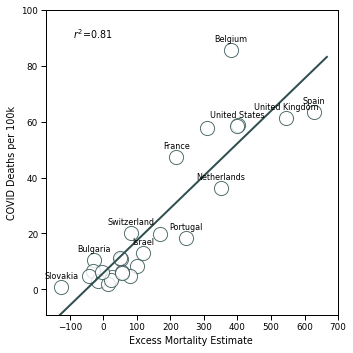

In [20]:
sns.set_context('paper')

fig, ax = plt.subplots(figsize=(5, 5))

sns.regplot('total_excess_p', 'total_deaths_per_100k', data=df.groupby('country').last(), 
            ci=False, truncate=False,
            scatter_kws=dict(edgecolor='darkslategrey', facecolor='w', s=200), 
            line_kws=dict(color='darkslategrey', lw=2))

show_countries = [
    'Spain', 'United Kingdom', 'United States', 'France', 'Netherlands', 'Portugal', 'Bulgaria', 'Slovakia',
    'Israel', 'Switzerland', 'Belgium'
]

df.groupby('country').last().reindex(show_countries).apply(
    lambda row: ax.text(row['total_excess_p'], row['total_deaths_per_100k']+4, row.name, fontsize=8, ha='center', va='center'), axis=1
)

ax.set_ylim(-9, 100)
ax.set_xlim(-170, 700)

ax.set_xlabel('Excess Mortality Estimate ')
ax.set_ylabel('COVID Deaths per 100k')

ax.text(-90, 90, '$r^2$={}'.format(
    round(df.groupby('country').last()[['total_deaths_per_100k', 'total_excess_p']].corr().values[0][1]**2, 2)))

fig.tight_layout()

fig.savefig('../graphs/covid_excess_correlation.png', dpi=300, format='png')

In [21]:
excess = df.groupby('country').last()[['total_excess_p', 'total_deaths_per_100k']].dropna()
x, y = excess['total_excess_p'], excess['total_deaths_per_100k']

slope, intercept, r_value, p_value, std_err = linregress(x, y)

def est_total_deaths_per_100k(p):
    return (slope*p) + intercept

(np.abs((x.map(est_total_deaths_per_100k)-y))/y)

country
Austria            1.069252
Belgium            0.416609
Bulgaria           0.756429
Czech Republic     1.118026
Denmark            0.097507
Estonia            2.119390
Finland            1.016728
France             0.341881
Germany            0.057587
Hungary            0.670010
Iceland            0.375794
Israel             0.513984
Italy              0.110384
Latvia             3.110314
Lithuania          1.640585
Luxembourg         0.280828
Netherlands        0.278500
Norway             0.815849
Poland             1.141795
Portugal           0.886855
Slovakia          13.537359
Slovenia           0.120917
Spain              0.239149
Sweden             0.277171
Switzerland        0.242512
United Kingdom     0.126812
United States      0.108372
dtype: float64

# The % COVID Burden
The covid burden is simply the a percentage based on the ratio of covid deaths to expected deaths on a given day.

In [22]:
total_expected_deaths = df.groupby('country').apply(
    lambda g: g[g['total_deaths_per_100k']>0].set_index('date')[['expected_daily_deaths_per_100k']].cumsum()
).rename(columns={'expected_daily_deaths_per_100k':'total_expected_deaths_per_100k'})

df = df.reset_index().set_index(['country', 'date']).join(total_expected_deaths).reset_index()

df['covid_burden'] = 100*df['total_deaths_per_100k']/df['total_expected_deaths_per_100k']
df['covid_burden'] = df['covid_burden'].replace(np.inf, np.nan)

df['annual_covid_burden'] = 100*df['total_deaths_per_100k']/df['expected_deaths_per_year_per_100k']
df['annual_covid_burden'] = df['annual_covid_burden'].replace(np.inf, np.nan)

df['country'].nunique()

188

# The Tadpole Graph

In [23]:
def plot_tail(ax, g, lw, width_scale=0.006, *args, **kwargs):
    g_next = g.shift(-1).add_suffix('_next')
    g = pd.concat([g, g_next], axis=1)
    
    for i, (_, (x, y, x_next, y_next)) in enumerate(g[:-1].iterrows()):
        ax.plot([x, x_next], [y, y_next], lw=lw*width_scale*i/len(g), **kwargs)

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


173

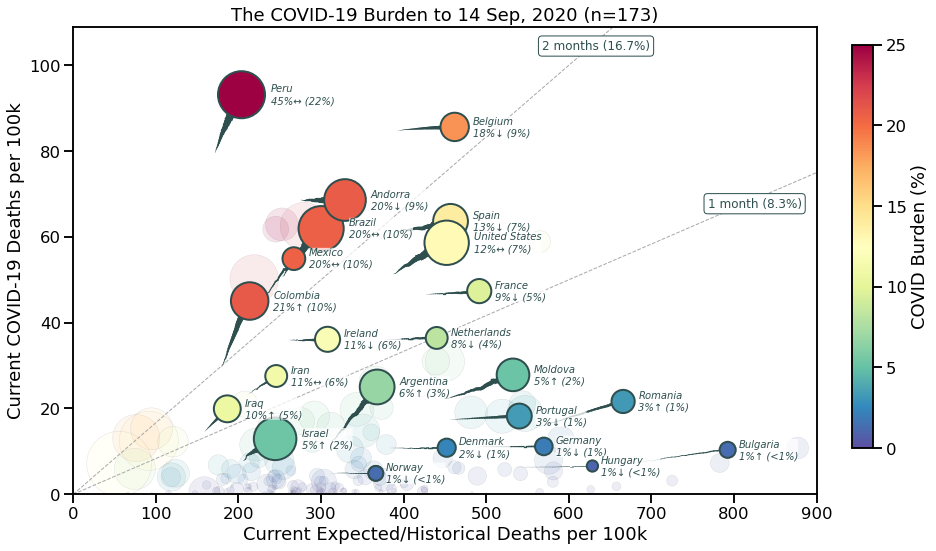

In [25]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 8))

# ax.grid(b='both', lw=.5, ls='--')

tail_length = 30  # The number of days to use for the tail of the tadpoles

# The colour map to use for the tadpole heads
use_palette = 'Spectral_r'

# The countries to highlight
show_countries = [
    'Peru', 'Belgium', 'Spain', 'Mexico', 'United States',
    'Ireland', 'France', 
    'Bulgaria', 
    'Iran', 'Israel', 'Brazil', 'Argentina', 'Norway', 'Andorra', 'Iraq',
    'Germany', 'Portugal', 'Netherlands', 'Norway', 'Denmark', 'Romania',
    'Moldova', 'Colombia', 'Hungary'
]

def plot_tadpoles(
    ax, df, 
    x='total_expected_deaths_per_100k', y='total_deaths_per_100k', size='total_cases_per_100k',
    use_palette=use_palette, show_countries=show_countries):
    
    norm = matplotlib.colors.Normalize(vmin=0, vmax=25)
    cmap = matplotlib.cm.get_cmap(use_palette)
    
    in_show_countries = df['country'].isin(show_countries)


    # Plot the tadpole tails

    df[in_show_countries].groupby('country').apply(
        lambda g: plot_tail(
            ax, 
            g[[x, y]].tail(tail_length),
            g[size].max(), c='darkslategrey', zorder=-10
        )    
    )

    # Plot the tadpole heads using the current covid burden.
    current_df = df.groupby('country').last().copy().dropna(subset=['covid_burden'])

    # Add the previous total_deaths_per_100k at start of tail.
    prev_total_deaths_per_100k = df.groupby('country').apply(
        lambda g: g[[y]].iloc[-tail_length]).rename(columns={y: 'prev_'+y})
    prev_covid_burden = df.groupby('country').apply(
        lambda g: g[['covid_burden']].iloc[-tail_length]).rename(columns={'covid_burden': 'prev_covid_burden'})

    
    current_df = current_df.join(prev_total_deaths_per_100k).join(prev_covid_burden)
    current_df[y+'_trend'] = (current_df[y]-current_df['prev_'+y])/current_df['prev_'+y]
    current_df['covid_burden_trend'] = (current_df['covid_burden']-current_df['prev_covid_burden'])/current_df['prev_covid_burden']


    all_colours = [cmap(norm(i)) for i in current_df['covid_burden']]
    marker_colours = [cmap(norm(i)) for i in current_df.reindex(show_countries)['covid_burden']]

    # The background heads
    ax.scatter(x, y, data=current_df,
               s=size, c=all_colours, edgecolor='k', lw=.5, alpha=.1, zorder=-100)

    # The coloured heads for the highlight countries.
    ax.scatter(x, y, data=current_df.reindex(show_countries),
               s=size, c=marker_colours, edgecolor='darkslategrey', lw=2, alpha=1)


    # Add the burden lines

    ax.set_xlim(0, 900)  
    
    def label_burden_line(x, burden):

        # Setup the label
        n = burden*12
        period = 'weeks' if n<1 else 'months'
        n = n*4 if n<1 else n
        period = 'month' if n==1 else period
        label = '{} {} ({}%)'.format(int(n), period, round(burden*100, 1))

        # Calculate the rotation angle
        y = 0.5+x*burden
        ax.text(
            x, y, label, 
            color='darkslategrey', ha='center', va='top', fontsize=12,
            bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),

    )


    for xpos, frac in [(825, 1/12), (633, 1/6)]:
        ax.plot(ax.get_xlim(), np.array(ax.get_xlim())*frac, c='darkgrey', lw=1, ls='dashed', zorder=-100)
        label_burden_line(xpos, frac)


    # Annotate highlight countries
    for country, row in current_df.iterrows():
        if country in show_countries:

            xpos, ypos = row[x], row[y]
            s = row[size]
            r = (s/2)**.5
            i = row['covid_burden']
            i = '<1' if i<1 else int(i)
            
            c = row['annual_covid_burden']
            c = '<1' if c<1 else int(c)

            
            if -.05 < row['covid_burden_trend'] < 0.05:
                dir_arrow = '↔'
            elif row['covid_burden_trend'] > 0.05:
                dir_arrow = '↑'
            else:
                dir_arrow = '↓'
                    
            label = '{}\n{}%{} ({}%)'.format(country, i, dir_arrow, c)

            ax.text(
                xpos+r+2, ypos, label, 
                fontsize=10, ha='left', va='center', color='darkslategrey', style='oblique',
                bbox=dict(facecolor='w', boxstyle='round,pad=0', lw=0, alpha=.75),
            )

    # Show the colourmap
    cax = fig.add_axes([1, .2, 0.025, .7])
    cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
    cb.set_label('COVID Burden (%)')

    return current_df

current_df = plot_tadpoles(ax, df)


# Finalise the axes
ax.set_xlim(0, 900)
ax.set_ylim(0, 109)

ax.set_xlabel('Current Expected/Historical Deaths per 100k')
ax.set_ylabel('Current COVID-19 Deaths per 100k')

ax.set_title('The COVID-19 Burden to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))






fig.tight_layout()
fig.savefig('../graphs/covid_burden_tadpoles.png', dpi=300, format='png', bbox_inches='tight')

current_df.index.nunique()

Here we see COVID deaths versus the expected deaths (both per 100,000 of population) over the same period of time. Each country is represented by a single marker (the head) with a tail, just like a tadpole. The size of the head is proportional to confirmed cases per capita and coloured according to its COVID burden, as per the scale shown. The tails indicate the trajectories of deaths for a country over the previous 30 days and, as such, help to highlight countries where deaths have been increasing (tails with an upward trajectory) and countries where deaths have been absent (horizontal tails). For example, countries such as Peru, the US, Israel, and Romania have tails that are indicative of increasing deaths -- the steeper the angle the greater the rate of increase -- whereas Ireland, the Netherlands, France, and Germany have tails that are horizontal, indicating no material increase in COVID deaths over the past 30 days.

Over time, all of the countries will move from the left to the right, as their expected number of deaths increases with each passing day, and they can move upwards as new COVID fatalities are registered, but they cannot move from right to left or downwards. 

Currently, most of the highlighted countries are associated with outbreaks that have been propgressing for 170-180 days and so their x-axis position reflects approximately 50% of their annual expected death rate; there is quite a bit of variation in these annual figures, even within similar regions. 

The diagonal guidelines on the graph show the trajectories associated with different COVID burden levels. For example, earlier we mentioned the hypothesis that COVID fatalities would be limited to approximately 1 month's worth of deaths for a given country. In fact, approximately 85% of the 173 countries analysed have a current COVID burden that is less than this level and the mean COVID burden is just under 4% currently. In other words only a minority of countries have exceeded this level today, adding some creedence to this hypotehsis; although while other factors explain higher rates, South American countries in particular appear to have accummulated significantly more that one month's worth of deaths. 

Currently, most countries (>70%) are experiencing rising fatality rates relative to a month ago, which means that their COVID burden is growing, although the rate of growth is much lower (23%) among those countries with a COVID Burden >12% compared with the rate of growth (70%) among those countries COVID burdens <12%.

This graph highlights some of the very different outbreak experiences around the world, but we do need to be mindful that differenceshows deaths are counted will account for at least some of the variance we see in the COVID burden and per capita death tolls. Nonetheless, it is worth highlighting countries such as Brazil, Mexico, Peru, all of which have growing COVID burdens of at least 20%. Peru presents with COVID burden of 46%, which is exceedingly high by any objective standard and is unlikely to be explained away but accounting differences, moreover, Peru's death toll has been increasing rapidly over the past month.

In comparison, most European countries have much lower COVID burdens, and in most of those shown, which do have higher burdens (Spain, France, Ireland, the Netherlands), COVID deaths have not been increasing significantly over the past month. In fact, overall only 50% of European countries are experiencing a COVID burden that has increased by more than 5% over the past 30 days, compared with 80% in North America and 100% in South America; by this measure Europe is leading the world.

In [26]:
current_df.shape

(173, 38)

In [27]:
1778/(30000*185/365)

0.11693153153153153

## Fraction of countries with different burdens

In [28]:
(current_df['covid_burden']<100/12).mean()

0.8554913294797688

In [29]:
(current_df['covid_burden']>100/6).mean()

0.06358381502890173

# Rank COVID Burden
Where does a country's covid burden rank in terms of the common causes of death for that country. CUrrently we only do this for the current covid burden using `current_df` rather than `df`.

## Compute the COVID rank

In [30]:
total_covid_deaths_by_country_code = df.groupby('country_code')[['new_deaths']].sum().rename(columns={'new_deaths': 'covid (deaths)'})
total_covid_deaths_by_country_code.loc['IRL']

covid (deaths)    1784.0
Name: IRL, dtype: float64

In [31]:
causes_of_death_by_country_with_covid = causes_of_death_by_country.set_index('country_code').join(total_covid_deaths_by_country_code).reset_index()
causes_of_death_by_country_with_covid.sample()

,country_code,country,Execution (deaths),Meningitis (deaths),Lower respiratory infections (deaths),Intestinal infectious diseases (deaths),Protein-energy malnutrition (deaths),Terrorism (deaths),Cardiovascular diseases (deaths),Dementia (deaths),...,Alcohol use disorders (deaths),Natural disasters (deaths),Diarrheal diseases (deaths),Heat (hot and cold exposure) (deaths),Nutritional deficiencies (deaths),Suicide (deaths),Conflict (deaths),Diabetes (deaths),Poisonings (deaths),covid (deaths)
198,UZB,Uzbekistan,0,282.002083,9748.549809,0.0,7.834817,0.0,115263.010503,4577.692481,...,310.495867,0.0,214.706991,246.496962,50.082757,3036.215109,0.0,6467.628656,340.77854,394.0


In [32]:
# The number of >0 causes
max_causes = pd.DataFrame(causes_of_death_by_country_with_covid.apply(lambda row: len(row.filter(like='(deaths)')[row.filter(like='(deaths)')>0]), axis=1)).rename(columns={0:'max_rank'})

# The rank of each >0 cause
rank_causes = causes_of_death_by_country_with_covid.apply(
    lambda row: 1+(len(row.filter(like='(deaths)')[row.filter(like='(deaths)')>0])-row.dropna().filter(like='(deaths)')[row.dropna().filter(like='(deaths)')>0].rank()), axis=1).add_suffix('_rank')

covid_rank_by_country_code = pd.concat([causes_of_death_by_country_with_covid, rank_causes, max_causes], axis=1).set_index('country_code')

covid_rank_by_country_code.loc['IRL']

country                                    Ireland
Execution (deaths)                               0
Meningitis (deaths)                        13.0685
Lower respiratory infections (deaths)      1371.93
Intestinal infectious diseases (deaths)          0
                                            ...   
Suicide (deaths)_rank                            9
Terrorism (deaths)_rank                        NaN
Tuberculosis (deaths)_rank                      21
covid (deaths)_rank                              5
max_rank                                        29
Name: IRL, Length: 70, dtype: object

## Add Rank & Days
We also compute a relative rank here, given that different countries/regions can have different numbers of non-zero causes.

In [33]:
current_df = current_df.reset_index().set_index('country_code').join(covid_rank_by_country_code[['covid (deaths)_rank', 'max_rank']]).rename(columns={'covid (deaths)_rank': 'covid_rank'})

current_df['rel_covid_rank'] = current_df['covid_rank']/current_df['max_rank']
current_df.loc['AUS']

country                                            Australia
date                                     2020-09-14 00:00:00
index                                                   2170
country_id                                                AU
continent                                            Oceania
region                                           australasia
new_cases                                                 44
new_deaths                                                 7
new_tests_smoothed                                     51249
population                                       2.54999e+07
new_cases_per_100k                                   0.17255
new_deaths_per_100k                                0.0274511
new_tests_smoothed_per_100k                          200.977
total_cases_per_100k                                 104.514
total_deaths_per_100k                                3.17649
total_tests_smoothed_per_100k                          26184
new_cases_per_100k_rolli

# Analysis by Continent

In [34]:
current_df[['covid_burden', 'total_deaths_per_100k']].corr()

,covid_burden,total_deaths_per_100k
covid_burden,1.000000,0.889991
total_deaths_per_100k,0.889991,1.000000


In [35]:
current_df.loc['IRL']

country                                              Ireland
date                                     2020-09-14 00:00:00
index                                                  17500
country_id                                                IE
continent                                             Europe
region                                                    eu
new_cases                                                255
new_deaths                                                 1
new_tests_smoothed                                     10241
population                                        4.9378e+06
new_cases_per_100k                                   5.16425
new_deaths_per_100k                                 0.020252
new_tests_smoothed_per_100k                            207.4
total_cases_per_100k                                 627.507
total_deaths_per_100k                                36.1295
total_tests_smoothed_per_100k                        18564.9
new_cases_per_100k_rolli

## Statististical Significance Tests

In [36]:
def check_contintent_significance(current_df, group_col='continent', result_col='covid_burden', p=.05):
    
    grouped_results = current_df.groupby(group_col).apply(lambda g: g[result_col].dropna().values)
    f = f_oneway(*grouped_results)
    
    if f.pvalue>p: return f, None
    
    else:
        stacked_data = current_df.groupby(group_col).apply(lambda g: pd.Series(g[result_col].dropna().values))
        stacked_data = stacked_data.unstack(-2).stack().reset_index()
        stacked_data.columns = ['id', 'group', 'result']

        tukey = MultiComparison(stacked_data['result'], stacked_data['group']).tukeyhsd()
        return f, tukey
    
f, tukey = check_contintent_significance(current_df, group_col='continent', result_col='covid_burden', p=.05)
f, print(tukey.summary())

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
       Africa          Asia   2.5578 0.2297  -0.7492  5.8648  False
       Africa        Europe   3.7186 0.0215    0.345  7.0922   True
       Africa North America   4.8035 0.0128    0.662   8.945   True
       Africa       Oceania   0.2765    0.9  -6.6174  7.1704  False
       Africa South America  13.9127  0.001   8.7879 19.0376   True
         Asia        Europe   1.1608    0.9  -2.3481  4.6696  False
         Asia North America   2.2457 0.6305  -2.0067  6.4981  False
         Asia       Oceania  -2.2813    0.9  -9.2424  4.6797  False
         Asia South America  11.3549  0.001     6.14 16.5698   True
       Europe North America   1.0849    0.9  -3.2195  5.3893  False
       Europe       Oceania  -3.4421 0.6897 -10.4351  3.5509  False
       Europe South America  10.1941  0.001   4.

(F_onewayResult(statistic=13.223449446805564, pvalue=7.436378340776818e-11),
 None)

## Comparison of Continents

In [37]:
current_df['covid_burden_trend_increasing'] = current_df['covid_burden_trend']>0


use_cols = ['covid_burden', 'covid_burden_trend', 'covid_burden_trend_increasing', 'covid_rank', 'rel_covid_rank', 'covid_days', 'max_rank', 'total_deaths_per_100k', 'total_cases_per_100k', 'expected_deaths_per_year_per_100k']

burden_by_continent = current_df.dropna(subset=use_cols).groupby('continent')[use_cols].agg(['count', 'mean', 'std']).sort_values([('covid_rank', 'mean')], ascending=True)
burden_by_continent

covid_burden                       covid_burden_trend            \
                     count       mean        std              count      mean   
continent                                                                       
South America           12  14.851333  14.003848                 12  0.574622   
Europe                  40   4.657201   5.319119                 40 -0.026066   
North America           21   5.742114   6.273590                 21  0.609531   
Asia                    43   3.496426   4.821526                 43  0.173110   
Oceania                  6   1.215084   1.596639                  6  0.539644   
Africa                  51   0.938597   1.334822                 51  0.116601   

                        covid_burden_trend_increasing                      \
                    std                         count      mean       std   
continent                                                                   
South America  0.702769                            12  0.750000  0.452267   
Europe         0.159345                            40  0.325000  0.474342   
North America  1.227409                            21  0.666667  0.483046   
Asia           0.527305                            43  0.488372  0.505781   
Oceania        1.357634                             6  0.333333  0.516398   
Africa         0.430924                            51  0.411765  0.497050   

              covid_rank  ...  max_rank total_deaths_per_100k             \
                   count  ...       std                 count       mean   
continent                 ...                                              
South America         12  ...  0.900337                    12  37.140648   
Europe                40  ...  0.716115                    40  21.124742   
North America         21  ...  1.016530                    21  16.975531   
Asia                  43  ...  1.527525                    43   5.849122   
Oceania                6  ...  0.836660                     6   3.708513   
Africa                51  ...  1.189167                    51   2.346684   

                         total_cases_per_100k                           \
                     std                count         mean         std   
continent                                                                
South America  31.126139                   12  1047.603981  797.204472   
Europe         22.116718                   40   528.101847  360.608445   
North America  17.445436                   21   637.129602  640.311977   
Asia            7.351428                   43   606.419520  931.779394   
Oceania         5.645190                    6   228.070016  439.517255   
Africa          4.000640                   51   140.374070  217.859434   

              expected_deaths_per_year_per_100k                           
                                          count         mean         std  
continent                                                                 
South America                                12   591.981284  145.440582  
Europe                                       40  1034.147250  280.806115  
North America                                21   674.232892  228.525155  
Asia                                         43   532.460404  241.753136  
Oceania                                       6   684.967699  145.560549  
Africa                                       51   636.015278  171.379658  

[6 rows x 30 columns]

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


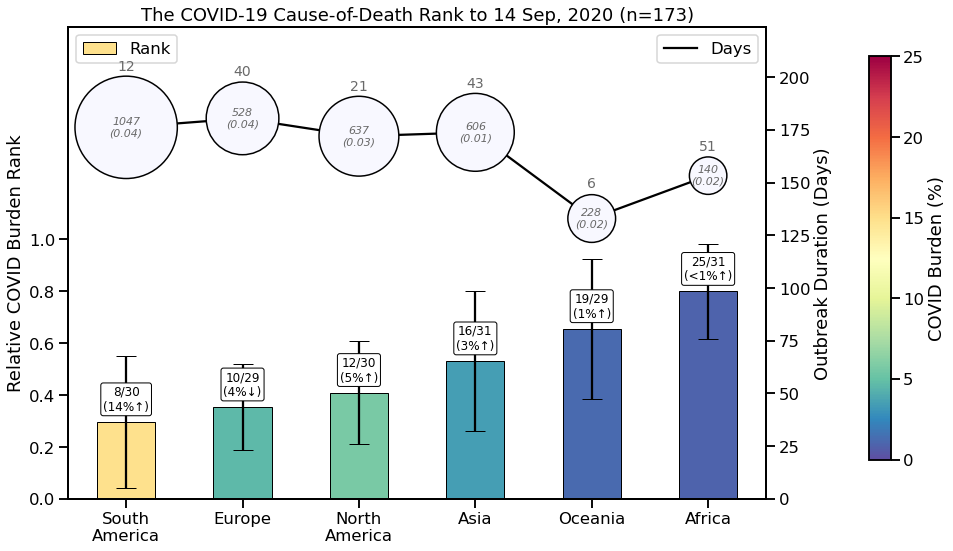

In [39]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 8))
bx=ax.twinx()


norm = matplotlib.colors.Normalize(vmin=0, vmax=25)
cmap = matplotlib.cm.get_cmap(use_palette)


# The colour map; because we shade the bars based on their average covid burden
bar_colours = [cmap(norm(i)) for i in burden_by_continent['covid_burden']['mean']]

# The main bar chart
burden_by_continent['rel_covid_rank']['mean'].plot(
    ax=ax, kind='bar', lw=1, edgecolor='k', color=bar_colours, 
    yerr=burden_by_continent['rel_covid_rank']['std'], capsize=10
)

# The days line graph
burden_by_continent['covid_days']['mean'].plot(ax=bx, c='k', zorder=-10)
bx.scatter(
    burden_by_continent.index, burden_by_continent['covid_days']['mean'], 
    s=burden_by_continent['total_cases_per_100k']['mean']*10, 
    color='ghostwhite', edgecolor='k'
)

burden_by_continent.apply(
    lambda row: bx.text(
        row.name, 
        row['covid_days']['mean']+(1+(row['total_cases_per_100k']['mean']*1)**.46), 
        int(row['covid_days']['count']), 
        ha='center', va='bottom', color='dimgrey', fontsize=14),
    axis=1
)

burden_by_continent.apply(
    lambda row: bx.text(
        row.name, 
        row['covid_days']['mean'], 
        '{}\n({})'.format(
            int(row['total_cases_per_100k']['mean']),
            round(row['total_deaths_per_100k']['mean']/row['total_cases_per_100k']['mean'], 2),
        ),
        ha='center', va='center', color='dimgrey', style='oblique', fontsize=11),
    axis=1
)

# The colour bar
cax = fig.add_axes([1.02, .18, 0.025, .7])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('COVID Burden (%)')

# Add rank labels.
for i, (continent, row) in enumerate(burden_by_continent.iterrows()):
    
    mean_covide_rank = int(round(row['covid_rank']['mean'], 1))
    mean_covid_max_rank = int(round(row['max_rank']['mean'], 1))
    
    mean_covid_burden = int(row['covid_burden']['mean'])
    mean_covid_burden = '<1' if mean_covid_burden==0 else mean_covid_burden
    trend_arrow = '↑' if row['covid_burden_trend']['mean']>0 else '↓'

    ax.text(
        i, row['rel_covid_rank']['mean']+.033, '{}/{}\n({}%{})'.format(
            mean_covide_rank, 
            mean_covid_max_rank,
            mean_covid_burden,
            trend_arrow
        ),
        ha='center', va='bottom', fontsize=12,
        bbox=dict(facecolor='w', boxstyle='round,pad=.2', lw=1, alpha=1),


    )


ax.set_ylim(0, 1.82)
ax.set_yticks(np.arange(0, 1.1, .2))
bx.set_ylim(0, 224)

ax.set_ylabel('Relative COVID Burden Rank')
bx.set_ylabel('Outbreak Duration (Days)')
ax.set_xlabel('')

ax.set_xticklabels([label.get_text().replace(' ', '\n') for label in ax.get_xticklabels()], rotation=0)

ax.legend(['Rank'], loc='upper left')
bx.legend(['Days'], loc='upper right')

ax.set_title('The COVID-19 Cause-of-Death Rank to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))


fig.tight_layout()

fig.savefig('../graphs/covid_burden_by_continent_bar.png', dpi=300, format='png', bbox_inches='tight')

To put this COVID burden in context, we use information on the number of fatalities per country per year across a variety of causes (e.g. cardiovascular disease, cancer, respiratory disease etc.) in order to rank COVID relative to these common causes of death. Not every country is associated with the same number of causes, so we convert this rank into a relative rank, such that a relative rank of 0 means that COVID is the leading single cause of death (acknowledging that is is problematic given co-morbidities etc.) in a particular country, while a relative rank of 1 means that it is the least common cause of death in that country.

The graph above shows the average relative rank for each continent as the bars (with corresponding standard deviations). The colour coding for the bars is based on the mean COVID burden for the corresponding continent, using the same colour-scale as previously. Each bar is also annotated with the average actual rank (not the relative rank) for the corresponding continent. The line graph presents the average number days since the first COVID death was registered in each continent alongwith th enumber of countries associated with each continent in our dataset. We can see that COVID ranks in the top-10 causes of deaths currently in South America and Europe, compared to top-20 and top-30 in Oceania and Africa, where there have been been fewer COVID-days.

In [40]:
burden_by_continent.filter(like='trend')

covid_burden_trend                      \
                           count      mean       std   
continent                                              
South America                 12  0.574622  0.702769   
Europe                        40 -0.026066  0.159345   
North America                 21  0.609531  1.227409   
Asia                          43  0.173110  0.527305   
Oceania                        6  0.539644  1.357634   
Africa                        51  0.116601  0.430924   

              covid_burden_trend_increasing                      
                                      count      mean       std  
continent                                                        
South America                            12  0.750000  0.452267  
Europe                                   40  0.325000  0.474342  
North America                            21  0.666667  0.483046  
Asia                                     43  0.488372  0.505781  
Oceania                                   6  0.333333  0.516398  
Africa                                   51  0.411765  0.497050

# Rank/Burden x Country
Next, let's look at the country burdens and their corersponding ranks.

In [42]:
map = gpd.read_file('../data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')[['ADM0_A3', 'geometry']].to_crs('+proj=robin').rename(columns={'ADM0_A3':'country_code'})

map_with_data = map.set_index('country_code').join(current_df[['covid_burden', 'covid_rank', 'max_rank', 'continent', 'region', 'population']])

map_with_data['coords'] = map_with_data['geometry'].apply(lambda x: x.representative_point().coords[0])


/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


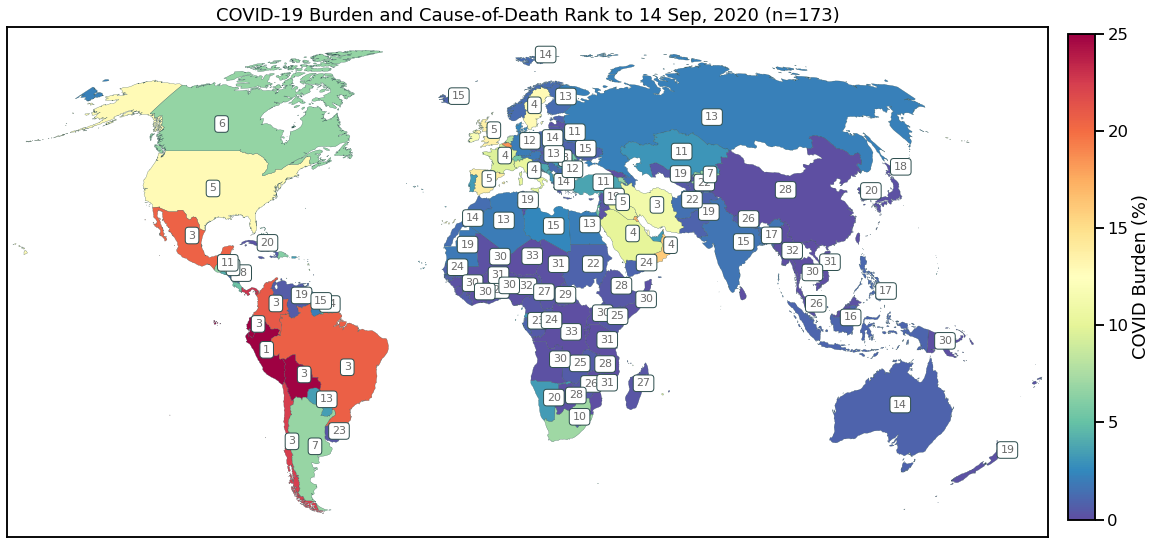

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))

map_with_data.plot(column='covid_burden', cmap=use_palette, norm=norm, ax=ax, lw=.25, edgecolor='darkslategrey')
min_area = 9.1e10

map_with_data[map_with_data['covid_rank'].notnull()].apply(
    lambda row: ax.annotate(
        '{}'.format(int(row['covid_rank'])), xy=row['coords'], fontsize=11, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)


    
ax.set_xlim(-1.5e7,1.7e7)



ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])


cax = fig.add_axes([1, .28, 0.025, .45])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('COVID Burden (%)')

ax.set_title('COVID-19 Burden and Cause-of-Death Rank to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))

fig.tight_layout()

fig.savefig('../graphs/covid_burden_world_map.png', dpi=300, format='png', bbox_inches='tight')

This map and the version below show the COVID rank for individual countries with each country coliour coded based on it's current COVID burden.

/home/barry/anaconda3/envs/covid-19/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


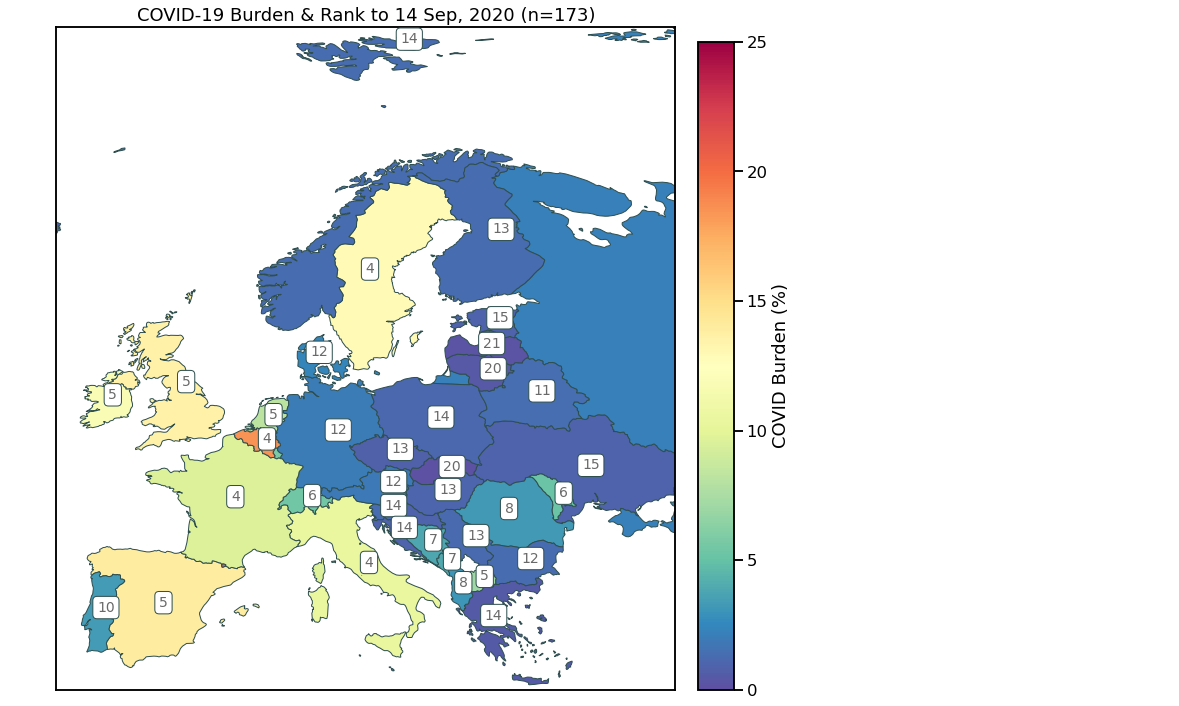

In [46]:
fig, ax = plt.subplots(figsize=(20, 20))

europe_map = map_with_data[map_with_data['continent']=='Europe']

europe_map.plot(
    column='covid_burden', cmap=use_palette, norm=norm, ax=ax, lw=1, edgecolor='darkslategrey')

min_area = 1e10

europe_map[europe_map['covid_rank'].notnull()].apply(
    lambda row: ax.annotate(
        '{}'.format(int(row['covid_rank'])), xy=row['coords'], fontsize=14, color='dimgrey',
        bbox=dict(facecolor='w', edgecolor='darkslategrey', boxstyle='round,pad=.3', lw=1),
    ) if row['geometry'].area>min_area else None, axis=1
)
    
    
ax.set_xlim(-.1e7,0.32e7)
ax.set_ylim(3.7e6, 8.2e6)

ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

cax = fig.add_axes([.48, .27, 0.025, .45])
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('COVID Burden (%)')


fig.tight_layout()

ax.set_title('COVID-19 Burden & Rank to {} (n={})'.format(df['date'].max().strftime('%d %b, %Y'), len(current_df)))



fig.savefig('../graphs/covid_burden_europe_map.png', dpi=300, format='png', bbox_inches='tight')

As expected, the harder hit European countries are associated with much lower COVID ranks than other European nations, particularly those in eastern Europe.

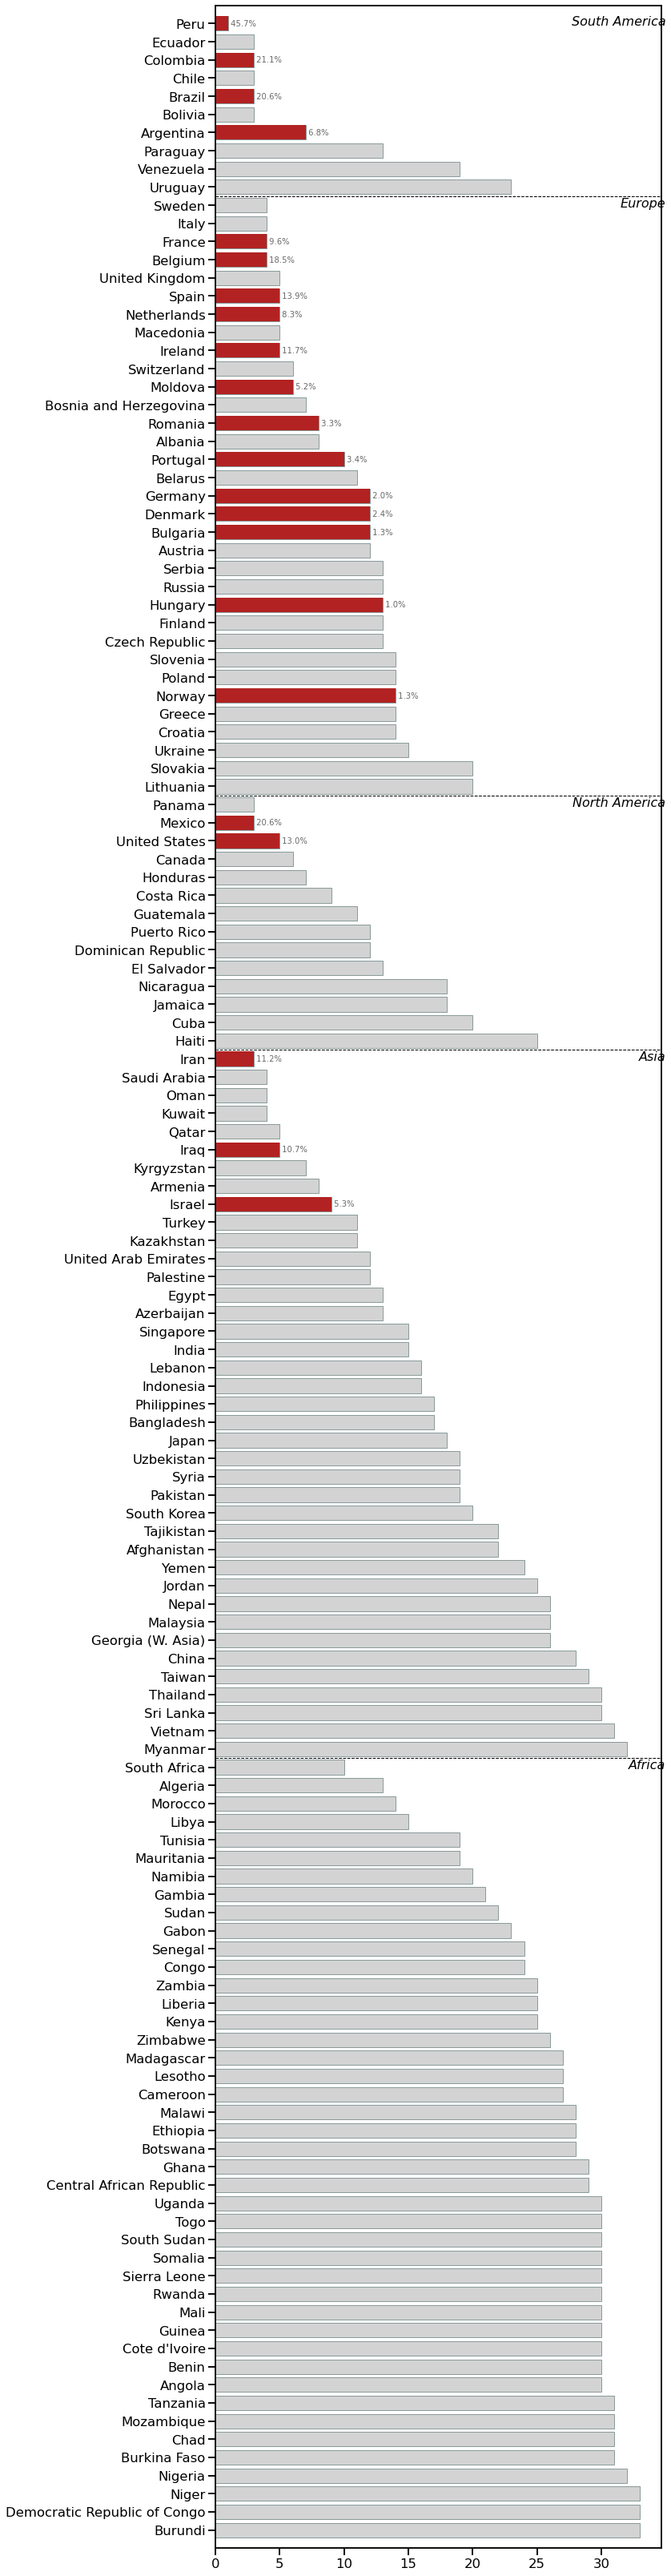

In [47]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 45))

min_pop = 2000000
with_min_pop = current_df['population']>min_pop

data_with_continent_burden = current_df[with_min_pop].reset_index().set_index('continent')\
    .join(pd.DataFrame(burden_by_continent.drop('Oceania')['covid_rank']['mean']).rename(columns={'mean':'mean_covid_rank_continent'}), how='inner')\
    .reset_index().set_index('country_code')\
    .sort_values(by=['mean_covid_rank_continent', 'covid_rank'], ascending=False)


ax.barh(data_with_continent_burden['country'], data_with_continent_burden['covid_rank'], color='lightgrey', edgecolor='darkslategrey', lw=.5)

highlight_countries = data_with_continent_burden['country'].isin(show_countries)

ax.barh(data_with_continent_burden[highlight_countries]['country'], data_with_continent_burden[highlight_countries]['covid_rank'], color='firebrick')


# Annotate the bars.
for _, (_, row) in enumerate(data_with_continent_burden[highlight_countries].iterrows()):
    x = row['covid_rank']
    y = row['country']
    v = row['covid_burden']
    ax.text(x, y, ' {}%'.format(round(v, 1)), fontsize=10, color='dimgrey', va='center')

# Add the Continent Labels
base = 0
for continent in data_with_continent_burden['continent'].unique():
    if base>0: ax.axhline(base-.5, lw=1, c='k', ls='--')
    base += len(data_with_continent_burden[data_with_continent_burden['continent']==continent])
    ax.text(35, base-1.1, continent, ha='right', fontsize=16, style='oblique')

ax.set_ylim(-1, len(data_with_continent_burden))
fig.tight_layout()

